In [2]:
import os
import torch
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import random_split, DataLoader, TensorDataset

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Define the root directory
root_dir = 'data'

# Get the list of directories (labels)
labels = os.listdir(root_dir)

# Initialize an empty list to store the images and labels
data = []
labels_list = []

# Loop over the directories
for label in labels:
    # Get the list of image files in the directory
    image_files = os.listdir(os.path.join(root_dir, label))
    
    # Loop over the image files
    for image_file in image_files:
        # Open the image file
        image = Image.open(os.path.join(root_dir, label, image_file))
        
        # Apply the transformation to the image and add it to the list
        data.append(transform(image))
        
        # Add the label to the list
        labels_list.append(int(label))

# Convert the list of images and labels to PyTorch tensors
data = torch.stack(data)
labels = torch.tensor(labels_list)
labels = labels - 1

# Create a TensorDataset from the data and labels
dataset = TensorDataset(data, labels)

# Define the size of the validation set
val_size = int(len(dataset) * 0.1)  # 20% 
train_size = len(dataset) - val_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
# Create DataLoaders for the training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)

# Print the sizes of the training and validation sets
print('Training set size:', len(train_dataset))
print('Validation set size:', len(val_dataset))

Training set size: 4618
Validation set size: 513


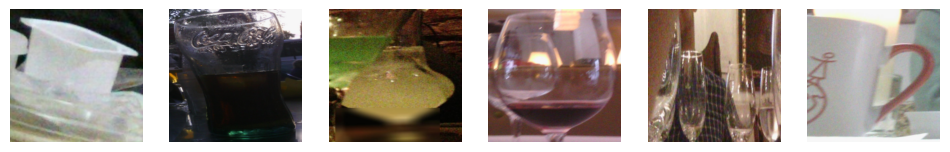

In [11]:
# visualize a sample image
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data
inputs, targets = next(iter(train_dataloader))

# Convert the images to numpy arrays
images = inputs.numpy()

# Plot the images
fig, axes = plt.subplots(figsize=(12, 6), ncols=6)
for i in range(6):
    axes[i].imshow(np.transpose(images[i], (1, 2, 0)))
    axes[i].axis('off')
plt.show()



In [12]:
# import torch.nn as nn
# import torch.nn.functional as F

# def accuracy(outputs, labels):
#     _, preds = torch.max(outputs, dim=1)
#     return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# class ImageClassificationBase(nn.Module):
    
#     def training_step(self, batch):
#         images, labels = batch 
#         out = self(images)                  # Generate predictions
#         loss = F.cross_entropy(out, labels) # Calculate loss
#         return loss
    
#     def validation_step(self, batch):
#         images, labels = batch 
#         out = self(images)                    # Generate predictions
#         loss = F.cross_entropy(out, labels)   # Calculate loss
#         acc = accuracy(out, labels)           # Calculate accuracy
#         return {'val_loss': loss.detach(), 'val_acc': acc}
        
#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# class ClassificationModel(ImageClassificationBase):
#     def __init__(self):
#         super().__init__()
#         self.network = nn.Sequential(
            
#             nn.Conv2d(3, 32, kernel_size = 5, padding = 1),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(32,64, kernel_size = 5, stride = 2, padding = 1),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.MaxPool2d(2,2),
#             # nn.Dropout(0.25),
        
#             nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.BatchNorm2d(128),
#             nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
#             nn.ReLU(),
#             nn.BatchNorm2d(128),
#             nn.MaxPool2d(2,2),
#             # nn.Dropout(0.25),
            
#             nn.Flatten(),
#             nn.Linear(57600,512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512,256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256,9)
#         )
    
#     def forward(self, xb):
#         return self.network(xb)


In [13]:
# @torch.no_grad()
# def evaluate(model, val_loader):
#     model.eval()
#     outputs = [model.validation_step(batch) for batch in val_loader]
#     return model.validation_epoch_end(outputs)

# def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
#     history = []
#     optimizer = opt_func(model.parameters(),lr)
#     for epoch in range(epochs):
        
#         model.train()
#         train_losses = []
#         for batch in train_loader:
#             loss = model.training_step(batch)
#             train_losses.append(loss)
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
            
#         result = evaluate(model, val_loader)
#         result['train_loss'] = torch.stack(train_losses).mean().item()
#         model.epoch_end(epoch, result)
#         history.append(result)
    
#     return history

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(growth_rate, growth_rate, kernel_size=3, padding=1)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = torch.cat([x, out], 1)  # Concatenate input with output along channels
        return out

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(x)
        out = self.pool(out)
        return out

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_layers=[6, 12, 24, 16], num_classes=9):
        super(DenseNet, self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('conv0', nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3))
        self.features.add_module('norm0', nn.BatchNorm2d(64))
        self.features.add_module('relu0', nn.ReLU(inplace=True))
        self.features.add_module('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        in_channels = 64
        for i, num_layers in enumerate(block_layers):
            block = self._make_dense_block(in_channels, growth_rate, num_layers)
            self.features.add_module(f'denseblock{i + 1}', block)
            in_channels += num_layers * growth_rate
            if i != len(block_layers) - 1:
                trans = self._make_transition_layer(in_channels, in_channels // 2)
                self.features.add_module(f'transition{i + 1}', trans)
                in_channels = in_channels // 2

        self.features.add_module('norm5', nn.BatchNorm2d(in_channels))
        self.features.add_module('relu5', nn.ReLU(inplace=True))
        self.features.add_module('pool5', nn.AdaptiveAvgPool2d((1, 1)))
        self.classifier = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = torch.flatten(features, 1)
        out = self.classifier(out)
        return out

    def _make_dense_block(self, in_channels, growth_rate, num_layers):
        layers = []
        for i in range(num_layers):
            layers.append(DenseBlock(in_channels + i * growth_rate, growth_rate))
        return nn.Sequential(*layers)

    def _make_transition_layer(self, in_channels, out_channels):
        return TransitionLayer(in_channels, out_channels)


In [19]:
from tqdm import tqdm

def fit(model, train_loader, val_loader, loss_function, optimizer, epochs):
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        train_correct = 0
        train_total = 0
        pbar = tqdm(train_loader, desc=f"Training epoch {epoch+1}")
        for i, (images, labels) in enumerate(pbar):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                if torch.cuda.is_available():
                    images = images.cuda()
                    labels = labels.cuda()

                outputs = model(images)
                loss = loss_function(outputs, labels)
                val_losses.append(loss.item())
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = np.mean(val_losses)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/best_model.pth')

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        train_accuracy = 100 * train_correct / train_total
        val_accuracy = 100 * val_correct / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss}, Val Loss: {val_loss}, Train Accuracy: {train_accuracy}%, Val Accuracy: {val_accuracy}%')

    return history

In [20]:
model = DenseNet()

In [21]:
if torch.cuda.is_available():
    model = model.cuda()

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

# Train the model
history = fit(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs=50)


Training epoch 1: 100%|██████████| 73/73 [00:29<00:00,  2.47it/s]


Epoch [1/50], Train Loss: 1.5163902076956344, Val Loss: 1.9048885769314237, Train Accuracy: 43.633607622347334%, Val Accuracy: 28.265107212475634%


Training epoch 2: 100%|██████████| 73/73 [00:28<00:00,  2.52it/s]


Epoch [2/50], Train Loss: 1.2589919387477717, Val Loss: 2.1642298698425293, Train Accuracy: 54.41749675184062%, Val Accuracy: 36.25730994152047%


Training epoch 3: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [3/50], Train Loss: 1.094054988802296, Val Loss: 2.152324398358663, Train Accuracy: 60.76223473365093%, Val Accuracy: 38.01169590643275%


Training epoch 4: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [4/50], Train Loss: 0.9381523834515925, Val Loss: 1.9795658323499892, Train Accuracy: 67.34517106972716%, Val Accuracy: 37.62183235867447%


Training epoch 5: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [5/50], Train Loss: 0.7791543353910315, Val Loss: 1.2422445482677884, Train Accuracy: 73.38674750974448%, Val Accuracy: 60.8187134502924%


Training epoch 6: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [6/50], Train Loss: 0.7148935978543268, Val Loss: 1.1953068574269612, Train Accuracy: 75.18406236466002%, Val Accuracy: 62.76803118908382%


Training epoch 7: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [7/50], Train Loss: 0.642181054778295, Val Loss: 0.9971495734320747, Train Accuracy: 77.65266349068861%, Val Accuracy: 66.66666666666667%


Training epoch 8: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [8/50], Train Loss: 0.5581058904732743, Val Loss: 0.8934349219004313, Train Accuracy: 80.79255088783023%, Val Accuracy: 67.83625730994152%


Training epoch 9: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [9/50], Train Loss: 0.4853627759299866, Val Loss: 0.9474983215332031, Train Accuracy: 82.89302728453876%, Val Accuracy: 67.83625730994152%


Training epoch 10: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [10/50], Train Loss: 0.44394011734283134, Val Loss: 0.742498536904653, Train Accuracy: 85.1883932438285%, Val Accuracy: 76.60818713450293%


Training epoch 11: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [11/50], Train Loss: 0.35324017662708074, Val Loss: 0.7263600619302856, Train Accuracy: 88.41489822433954%, Val Accuracy: 75.04873294346979%


Training epoch 12: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [12/50], Train Loss: 0.33604983270984806, Val Loss: 1.3612613611751132, Train Accuracy: 89.06453009961022%, Val Accuracy: 69.20077972709552%


Training epoch 13: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [13/50], Train Loss: 0.3158046597079055, Val Loss: 0.7366561231513818, Train Accuracy: 89.67085318319619%, Val Accuracy: 75.63352826510722%


Training epoch 14: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [14/50], Train Loss: 0.2420754322450455, Val Loss: 0.49404377629980445, Train Accuracy: 92.16110870506712%, Val Accuracy: 82.26120857699804%


Training epoch 15: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [15/50], Train Loss: 0.19702479835242442, Val Loss: 0.5099363492594825, Train Accuracy: 93.98007795582504%, Val Accuracy: 84.60038986354776%


Training epoch 16: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [16/50], Train Loss: 0.24258373693039972, Val Loss: 0.6290361914369795, Train Accuracy: 91.96621914248593%, Val Accuracy: 79.33723196881091%


Training epoch 17: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [17/50], Train Loss: 0.17604266790902778, Val Loss: 0.7450200584199693, Train Accuracy: 94.32654828930274%, Val Accuracy: 77.58284600389864%


Training epoch 18: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [18/50], Train Loss: 0.13429017722198408, Val Loss: 0.5683983133898841, Train Accuracy: 95.88566478995236%, Val Accuracy: 82.26120857699804%


Training epoch 19: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [19/50], Train Loss: 0.08726497877338162, Val Loss: 0.40439571397534263, Train Accuracy: 97.63967085318319%, Val Accuracy: 87.13450292397661%


Training epoch 20: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [20/50], Train Loss: 0.07549545917762061, Val Loss: 0.4953913336826695, Train Accuracy: 97.63967085318319%, Val Accuracy: 84.21052631578948%


Training epoch 21: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [21/50], Train Loss: 0.06749430334527198, Val Loss: 0.4886366688232455, Train Accuracy: 98.2243395409268%, Val Accuracy: 85.38011695906432%


Training epoch 22: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [22/50], Train Loss: 0.15330236596501853, Val Loss: 0.5362280044290755, Train Accuracy: 95.10610653962755%, Val Accuracy: 85.38011695906432%


Training epoch 23: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [23/50], Train Loss: 0.09953435806378927, Val Loss: 0.6811627772791932, Train Accuracy: 97.03334776959723%, Val Accuracy: 78.75243664717348%


Training epoch 24: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [24/50], Train Loss: 0.10785768372453239, Val Loss: 0.535166475094027, Train Accuracy: 96.4053702901689%, Val Accuracy: 82.06627680311891%


Training epoch 25: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [25/50], Train Loss: 0.08723559811047904, Val Loss: 0.47019529250812614, Train Accuracy: 97.74794283239498%, Val Accuracy: 85.7699805068226%


Training epoch 26: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [26/50], Train Loss: 0.1252461956839447, Val Loss: 0.5020886179473665, Train Accuracy: 95.75573841489822%, Val Accuracy: 84.99025341130604%


Training epoch 27: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [27/50], Train Loss: 0.04988138410836866, Val Loss: 0.6017551534912653, Train Accuracy: 98.48419229103509%, Val Accuracy: 81.87134502923976%


Training epoch 28: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [28/50], Train Loss: 0.021367240984196942, Val Loss: 0.39263314712378716, Train Accuracy: 99.6535296665223%, Val Accuracy: 88.30409356725146%


Training epoch 29: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [29/50], Train Loss: 0.06846914710859729, Val Loss: 0.7420074244340261, Train Accuracy: 97.96448679081854%, Val Accuracy: 84.21052631578948%


Training epoch 30: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [30/50], Train Loss: 0.035240749566981644, Val Loss: 0.4365186355328963, Train Accuracy: 99.28540493720226%, Val Accuracy: 85.7699805068226%


Training epoch 31: 100%|██████████| 73/73 [00:28<00:00,  2.53it/s]


Epoch [31/50], Train Loss: 0.06374389370137902, Val Loss: 1.2012496325704787, Train Accuracy: 98.50584668687743%, Val Accuracy: 80.11695906432749%


Training epoch 32:  95%|█████████▍| 69/73 [00:27<00:01,  2.47it/s]


KeyboardInterrupt: 

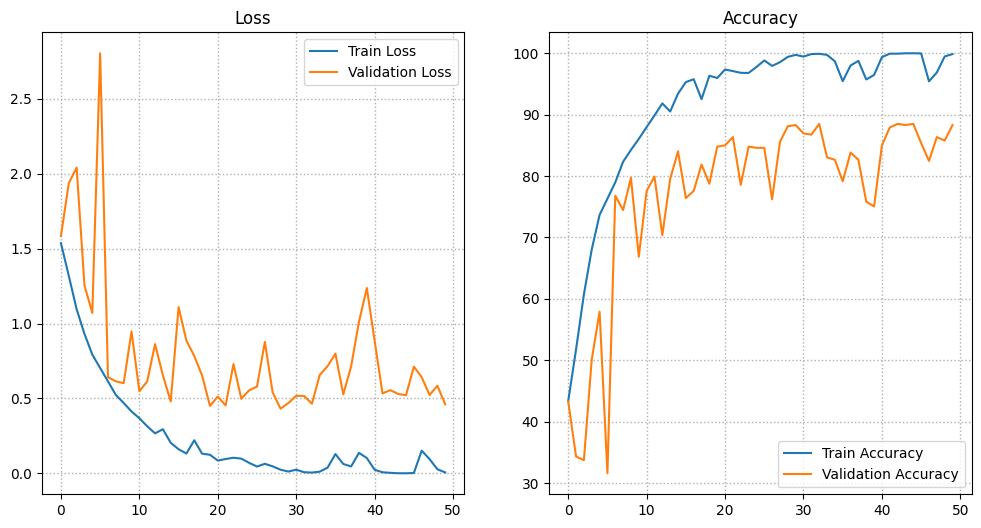

In [ ]:
# Plot the training and validation loss and accuracy in another graph

import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss')
    ax1.legend()
    ax1.grid(which='both', linestyle=':', linewidth=1)

    ax2.plot(history['train_accuracy'], label='Train Accuracy')
    ax2.plot(history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    ax2.grid(which='both', linestyle=':', linewidth=1)

    plt.show()

plot_training_history(history)

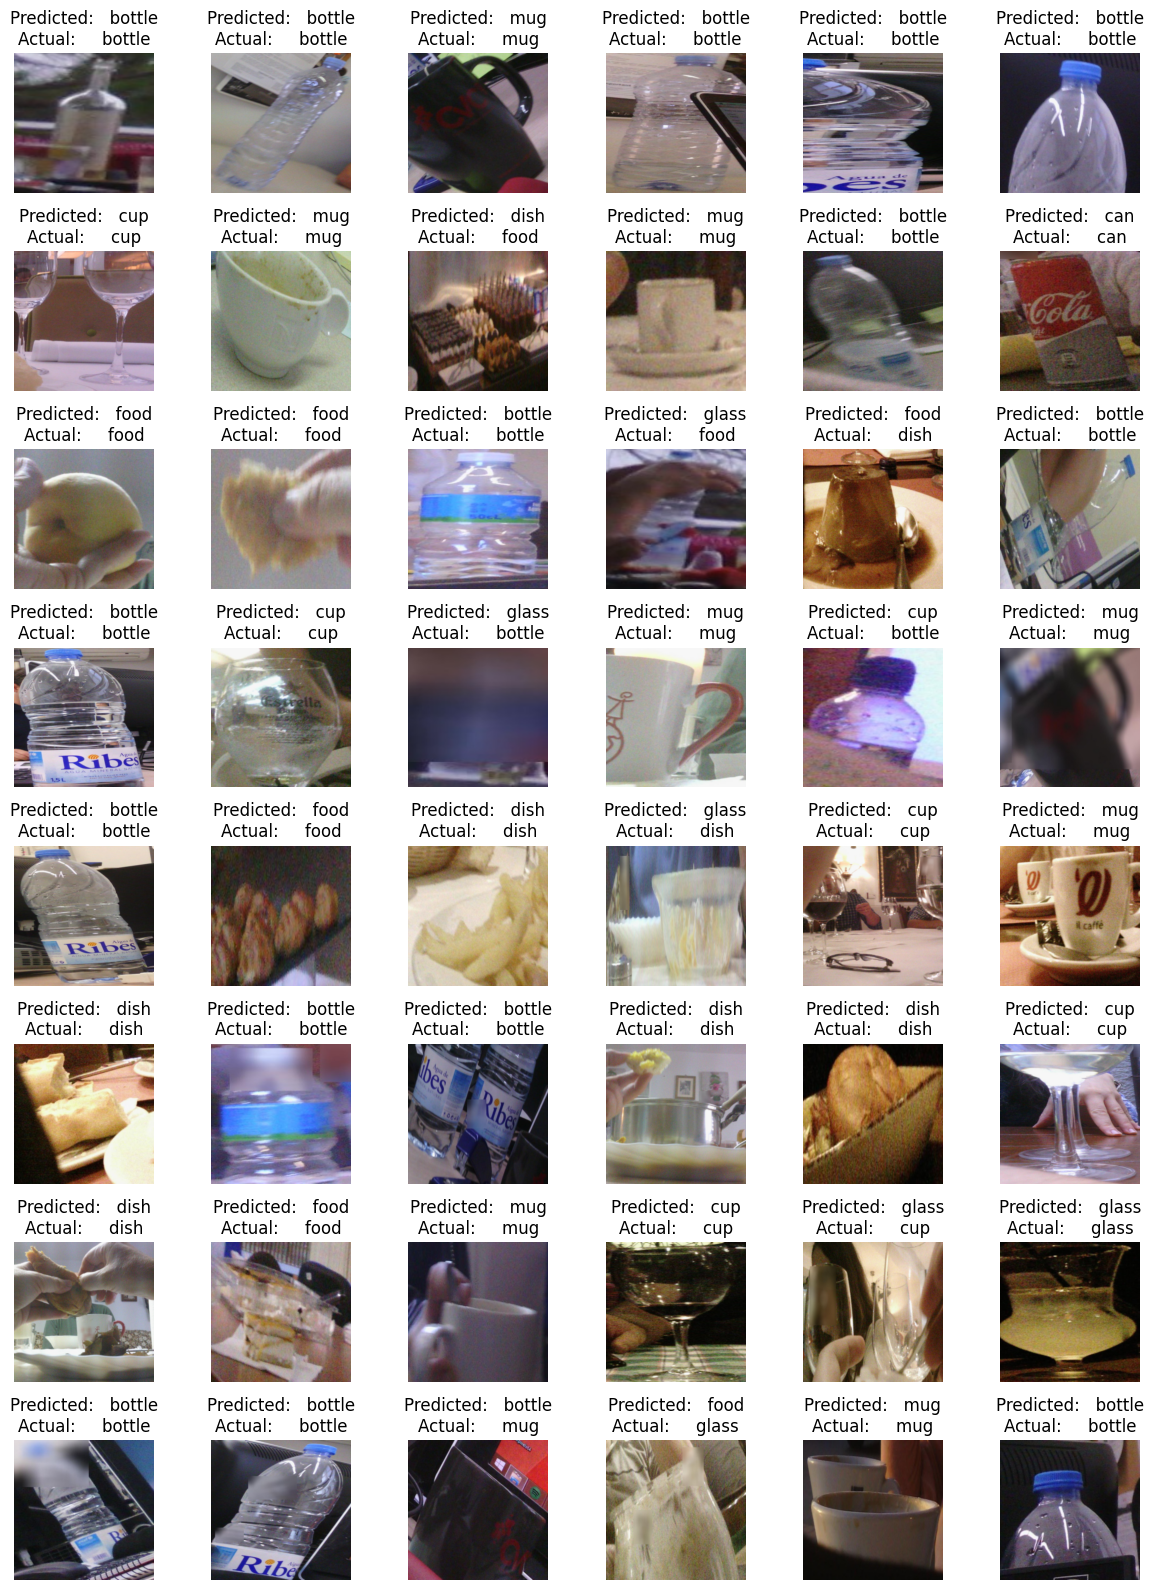

In [96]:
with open('category.txt', 'r') as f:
    next(f) 
    categories = f.readlines()
categories = [x.strip().split('\t')[1] for x in categories]


with open('category.txt', 'r') as f:
    next(f)  # Skip the header line
    categories = f.readlines()
categories = [x.strip().split('\t')[1] for x in categories]


def predict_image(img, modelf):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get predictions from model
    yb = modelf(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds[0].item()

# Load the best model 
best_model = DenseNet()
best_model.load_state_dict(torch.load('models/best_model.pth'))

# Get a batch of validation data
test_dataloader = DataLoader(val_dataset, batch_size=48, shuffle=True)

# Get a batch of validation data
inputs, labels = next(iter(test_dataloader))

# Make predictions
preds = best_model(inputs)

# Convert the images to numpy arrays
images = inputs.numpy()

# Calculate the number of rows and columns
n_images = len(images)
n_cols = 6
n_rows = n_images // n_cols + (n_images % n_cols > 0)

# Create a figure with the calculated number of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))

# Flatten the axes array in case it's multidimensional
axes = axes.flatten()

# Plot the images along with the predicted labels
for i in range(n_images):
    axes[i].imshow(np.transpose(images[i], (1, 2, 0)))
    axes[i].set_title(f'Predicted:   {categories[preds[i].argmax()]}\nActual:     {categories[labels[i]]}')
    axes[i].axis('off')

# Hide the remaining axes
for i in range(n_images, n_rows * n_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [ ]:
# model = ClassificationModel()
# model

In [ ]:
# def get_default_device():
#     """ Set Device to GPU or CPU"""
#     if torch.cuda.is_available():
#         return torch.device('cuda')
#     else:
#         return torch.device('cpu')
    

# def to_device(data, device):
#     "Move data to the device"
#     if isinstance(data,(list,tuple)):
#         return [to_device(x,device) for x in data]
#     return data.to(device,non_blocking = True)

# class DeviceDataLoader():
#     """ Wrap a dataloader to move data to a device """
    
#     def __init__(self, dl, device):
#         self.dl = dl
#         self.device = device
    
#     def __iter__(self):
#         """ Yield a batch of data after moving it to device"""
#         for b in self.dl:
#             yield to_device(b,self.device)
            
#     def __len__(self):
#         """ Number of batches """
#         return len(self.dl) 

In [ ]:
# device = get_default_device()
# device

In [ ]:
# train_dataloader = DeviceDataLoader(train_dataloader, device)
# val_dataloader = DeviceDataLoader(val_dataloader, device)
# to_device(model, device)

In [ ]:
# model = to_device(ClassificationModel(),device)

In [ ]:
# num_epochs = 10
# opt_func = torch.optim.Adam
# lr = 0.001
# #fitting the model on training data and record the result after each epoch
# history = fit(num_epochs, lr, model, train_dataloader, val_dataloader, opt_func)

In [ ]:
# # visualize output number
# Tmodel = nn.Sequential(
#     nn.Conv2d(3, 32, kernel_size = 5, padding = 1),
#     nn.ReLU(),
#     nn.Conv2d(32,64, kernel_size = 5, stride = 2, padding = 1),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),

#     nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
#     nn.ReLU(),
#     nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),
    
#     nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
#     nn.ReLU(),
#     nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),
    
#     nn.Flatten(),
# )

# # Pass a batch of input through the model up to the flatten layer
# x = torch.randn(1, 3, 256, 256)
# x = Tmodel[:](x)

# # Print the shape of the output
# print(x.shape)

In [ ]:
#just for visualizing output of each layer

class TDenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(TDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(growth_rate, growth_rate, kernel_size=3, padding=1)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = torch.cat([x, out], 1)  # Concatenate input with output along channels
        return out

class TTransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TTransitionLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(x)
        out = self.pool(out)
        return out

class TDenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_layers=[6, 12, 24, 16], num_classes=9):
        super(TDenseNet, self).__init__()
        self.features = nn.Sequential()
        self.features.add_module('conv0', nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3))
        self.features.add_module('norm0', nn.BatchNorm2d(64))
        self.features.add_module('relu0', nn.ReLU(inplace=True))
        self.features.add_module('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        in_channels = 64
        for i, num_layers in enumerate(block_layers):
            block = self._make_dense_block(in_channels, growth_rate, num_layers)
            self.features.add_module(f'denseblock{i + 1}', block)
            in_channels += num_layers * growth_rate
            if i != len(block_layers) - 1:
                trans = self._make_transition_layer(in_channels, in_channels // 2)
                self.features.add_module(f'transition{i + 1}', trans)
                in_channels = in_channels // 2

        self.features.add_module('norm5', nn.BatchNorm2d(in_channels))
        self.features.add_module('relu5', nn.ReLU(inplace=True))
        self.features.add_module('pool5', nn.AdaptiveAvgPool2d((1, 1)))
        self.classifier = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        for name, module in self.features.named_children():
            x = module(x)
            print(f'{name}: {x.shape}')
        out = torch.flatten(x, 1)
        out = self.classifier(out)
        return out

    def _make_dense_block(self, in_channels, growth_rate, num_layers):
        layers = []
        for i in range(num_layers):
            layers.append(TDenseBlock(in_channels + i * growth_rate, growth_rate))
        return nn.Sequential(*layers)

    def _make_transition_layer(self, in_channels, out_channels):
        return TTransitionLayer(in_channels, out_channels)

In [ ]:
Tmodel = TDenseNet()
input = torch.randn(1, 3, 512, 512)
output = Tmodel(input)

conv0: torch.Size([1, 64, 256, 256])
norm0: torch.Size([1, 64, 256, 256])
relu0: torch.Size([1, 64, 256, 256])
pool0: torch.Size([1, 64, 128, 128])
denseblock1: torch.Size([1, 256, 128, 128])
transition1: torch.Size([1, 128, 64, 64])
denseblock2: torch.Size([1, 512, 64, 64])
transition2: torch.Size([1, 256, 32, 32])
denseblock3: torch.Size([1, 1024, 32, 32])
transition3: torch.Size([1, 512, 16, 16])
denseblock4: torch.Size([1, 1024, 16, 16])
norm5: torch.Size([1, 1024, 16, 16])
relu5: torch.Size([1, 1024, 16, 16])
pool5: torch.Size([1, 1024, 1, 1])
